# Transfer Learning using MobileNetV3_Small

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

2022-05-02 15:45:34.550628: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-02 15:45:34.550654: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data_dir =pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Training and Validation')
test_dir =pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Testing')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1520


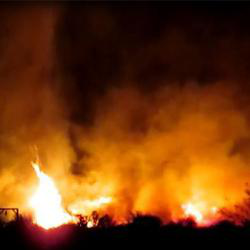

In [4]:
fire = list(data_dir.glob('fire/*'))
img = PIL.Image.open(str(fire[0]))
display(img)

### Load data into a tf dataset

Image input sizes: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [5]:
batch_size = 32
img_height = 224
img_width = 224

# Validation split 80/20

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )

Found 1520 files belonging to 2 classes.
Using 1216 files for training.


2022-05-02 15:45:35.913594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 15:45:35.913783: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-02 15:45:35.913819: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-05-02 15:45:35.913850: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-05-02 15:45:35.913879: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size    
    )


Found 1520 files belonging to 2 classes.
Using 304 files for validation.


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )

Found 381 files belonging to 2 classes.


### Get Class Names

In [8]:
class_names = train_ds.class_names
print(class_names)

['fire', 'nofire']


### Visualise Data

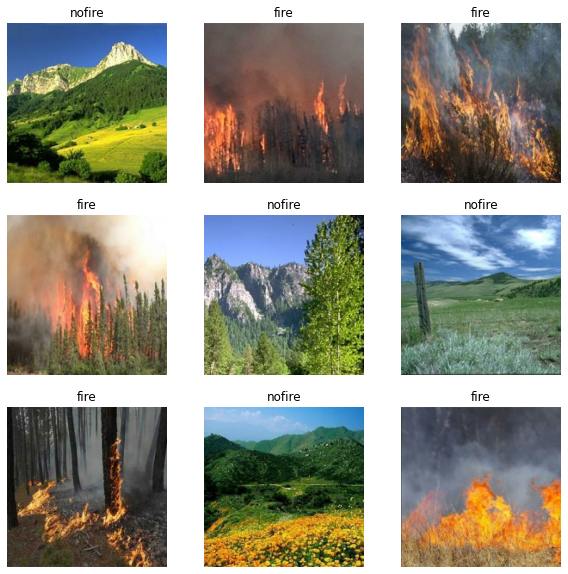

In [9]:
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Configure the dataset for performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size = AUTOTUNE)

### Create the base model from pre-trained convnets

In [11]:
## By specifying "include_top=False" argument you load a network that doesn't 
## include the classification layers at the top, which is ideal for feature extraction

IMG_SHAPE = (img_width, img_height) + (3,)

base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=IMG_SHAPE,
    alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation='softmax',
    include_preprocessing=True

)


image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)





(32, 7, 7, 576)


## Feature Extraction

In [12]:
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

 expanded_conv_1/depthwise/Batc  (None, 28, 28, 72)  288         ['expanded_conv_1/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_4 (ReLU)                 (None, 28, 28, 72)   0           ['expanded_conv_1/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_1/project (Conv2  (None, 28, 28, 24)  1728        ['re_lu_4[0][0]']                
 D)                                                                                               
                                                                                                  
 expanded_conv_1/project/BatchN  (None, 28, 28, 24)  96          ['expanded_conv_1/project[0][0]']
 orm (Batc

                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 24)    2328        ['expanded_conv_3/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 24)    0           ['expanded_conv_3/squeeze_excite/
 /Relu (ReLU)                                                    Conv[0][0]']                     
                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 96)    2400        ['expanded_conv_3/squeeze_excite/
 /Conv_1 (Conv2D)                                                Relu[0][0]']                     
                                                                                                  
 tf.__oper

                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 14, 14, 240)  0          ['multiply_4[0][0]',             
 /Mul (Multiply)                                                  'tf.math.multiply_7[0][0]']     
                                                                                                  
 expanded_conv_4/project (Conv2  (None, 14, 14, 40)  9600        ['expanded_conv_4/squeeze_excite/
 D)                                                              Mul[0][0]']                      
                                                                                                  
 expanded_conv_4/project/BatchN  (None, 14, 14, 40)  160         ['expanded_conv_4/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_

                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 14, 14, 120)  4800       ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
                                                                                                  
 expanded_conv_6/expand/BatchNo  (None, 14, 14, 120)  480        ['expanded_conv_6/expand[0][0]'] 
 rm (BatchNormalization)                                                                          
                                                                                                  
 tf.__operators__.add_11 (TFOpL  (None, 14, 14, 120)  0          ['expanded_conv_6/expand/BatchNor
 ambda)                                                          m[0][0]']                        
          

                                                                 m[0][0]',                        
                                                                  'tf.math.multiply_14[0][0]']    
                                                                                                  
 expanded_conv_7/depthwise (Dep  (None, 14, 14, 144)  3600       ['multiply_9[0][0]']             
 thwiseConv2D)                                                                                    
                                                                                                  
 expanded_conv_7/depthwise/Batc  (None, 14, 14, 144)  576        ['expanded_conv_7/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_15 (TFOpL  (None, 14, 14, 144)  0          ['expanded_conv_7/depthwise/Batch
 ambda)   

 tf.__operators__.add_18 (TFOpL  (None, 7, 7, 288)   0           ['expanded_conv_8/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_23 (ReLU)                (None, 7, 7, 288)    0           ['tf.__operators__.add_18[0][0]']
                                                                                                  
 tf.math.multiply_18 (TFOpLambd  (None, 7, 7, 288)   0           ['re_lu_23[0][0]']               
 a)                                                                                               
                                                                                                  
 multiply_12 (Multiply)         (None, 7, 7, 288)    0           ['expanded_conv_8/depthwise/Batch
                                                                 Norm[0][0]',                     
          

 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
                                                                                                  
 expanded_conv_9/squeeze_excite  (None, 1, 1, 144)   0           ['expanded_conv_9/squeeze_excite/
 /Relu (ReLU)                                                    Conv[0][0]']                     
                                                                                                  
 expanded_conv_9/squeeze_excite  (None, 1, 1, 576)   83520       ['expanded_conv_9/squeeze_excite/
 /Conv_1 (Conv2D)                                                Relu[0][0]']                     
                                                                                                  
 tf.__operators__.add_22 (TFOpL  (None, 1, 1, 576)   0           ['expanded_conv_9/squeeze_excite/
 ambda)                                                          Conv_1[0][0]']                   
          

                                                                                                  
 tf.math.multiply_25 (TFOpLambd  (None, 1, 1, 576)   0           ['re_lu_30[0][0]']               
 a)                                                                                               
                                                                                                  
 expanded_conv_10/squeeze_excit  (None, 7, 7, 576)   0           ['multiply_16[0][0]',            
 e/Mul (Multiply)                                                 'tf.math.multiply_25[0][0]']    
                                                                                                  
 expanded_conv_10/project (Conv  (None, 7, 7, 96)    55296       ['expanded_conv_10/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_

## Add classification head

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 576)


In [14]:
prediction_layer = tf.keras.layers.Dense(1, activation = 'sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


### Chain together the model

In [15]:
inputs = tf.keras.Input(shape = (IMG_SHAPE))
x = base_model(inputs, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [16]:
# Useful metrics paper:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=(True)),
              metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'), tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall"),tf.keras.metrics.AUC(name = "auc")] )

In [17]:

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 1)                 577       
                                                                 
Total params: 939,697
Trainable params: 577
Non-trainable par

## Train the model

In [18]:
# Tests the initial base model
initial_epochs = 10
loss0, accuracy0, precision0, recall0, auc0 = model.evaluate(val_ds)

/home/charlie/miniconda3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


10/10 [==============================] - 2s 108ms/step - loss: 0.7518 - accuracy: 0.4836 - precision: 0.4753 - recall: 0.5168 - auc: 0.4518


In [19]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
print("initial precision: {:.2f}".format(precision0))
print("initial recall: {:.2f}".format(recall0))
print("initial auc: {:.2f}".format(auc0))

initial loss: 0.75
initial accuracy: 0.48
initial precision: 0.48
initial recall: 0.52
initial auc: 0.45


In [20]:
history = model.fit(train_ds,
                    epochs = initial_epochs,
                    validation_data = val_ds)

Epoch 1/10
38/38 [==============================] - 8s 147ms/step - loss: 0.7243 - accuracy: 0.5378 - precision: 0.5391 - recall: 0.5532 - auc: 0.5399 - val_loss: 0.6654 - val_accuracy: 0.6086 - val_precision: 0.6027 - val_recall: 0.5906 - val_auc: 0.6342
Epoch 2/10
38/38 [==============================] - 6s 152ms/step - loss: 0.6349 - accuracy: 0.6365 - precision: 0.6411 - recall: 0.6285 - auc: 0.6912 - val_loss: 0.5932 - val_accuracy: 0.7204 - val_precision: 0.7424 - val_recall: 0.6577 - val_auc: 0.7836
Epoch 3/10
38/38 [==============================] - 6s 145ms/step - loss: 0.5804 - accuracy: 0.6974 - precision: 0.7120 - recall: 0.6678 - auc: 0.7754 - val_loss: 0.5313 - val_accuracy: 0.7829 - val_precision: 0.8268 - val_recall: 0.7047 - val_auc: 0.8797
Epoch 4/10
38/38 [==============================] - 5s 140ms/step - loss: 0.5175 - accuracy: 0.7788 - precision: 0.8000 - recall: 0.7463 - auc: 0.8629 - val_loss: 0.4792 - val_accuracy: 0.8520 - val_precision: 0.8881 - val_recall: 0

### Learning Curves

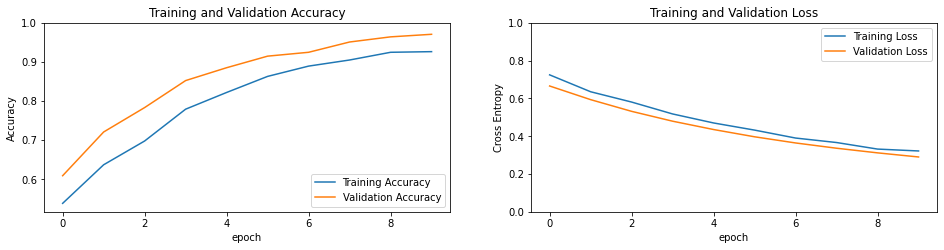

In [21]:
recall = history.history['recall']
val_recall = history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

auc = history.history['auc']
val_auc = history.history['val_auc']

precision = history.history['precision']
val_pre = history.history['val_precision']

accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize = (16, 16))


plt.subplot(4, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(4, 2, 1)
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

'''
plt.subplot(4, 2, 1)
plt.plot(recall, label = 'Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Recall')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Recall')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )

plt.subplot(4, 2, 3)
plt.plot(auc, label = 'Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.ylabel('AUC')
plt.ylim([0,1.0])
plt.title('Training and Validation AUC')
plt.xlabel('epoch')

plt.subplot(4, 2, 4)
plt.plot(precision, label = 'Training Precision')
plt.plot(val_pre, label='Validation Precision')
plt.legend(loc='upper right')
plt.ylabel('Precision')
plt.ylim([0,1.0])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')

'''
plt.show()




## Fine Tuning

In [22]:
# Previously the base model weights were not updated and only a few layers on top of the EfficientNetV2 was trained
# Unfreeze and train the top layers of the pre-trained model to fine tune to the dataset

## Un-freeze top layers of the model

base_model.trainable = True

In [23]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  229


In [24]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

### Compile the Model

In [25]:
## Important to use a lower training weight since using more layers, otherwise
# it could overfit very quickly 

model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate/10),
              metrics = [tf.keras.metrics.BinaryAccuracy(name = "accuracy"),
                         tf.keras.metrics.Precision(name = "precision"), 
                         tf.keras.metrics.Recall(name = "recall"),
                         tf.keras.metrics.AUC(name = "auc")])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 1)                 577       
                                                                 
Total params: 939,697
Trainable params: 814,113
Non-trainable

In [26]:
print(len(model.trainable_variables))


75


### Continue Training the Model

In [27]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs = total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = val_ds)


Epoch 10/20
38/38 [==============================] - 13s 263ms/step - loss: 0.2227 - accuracy: 0.9490 - precision: 0.9757 - recall: 0.9214 - auc: 0.9931 - val_loss: 0.1531 - val_accuracy: 0.9836 - val_precision: 0.9865 - val_recall: 0.9799 - val_auc: 0.9991
Epoch 11/20
38/38 [==============================] - 9s 234ms/step - loss: 0.1321 - accuracy: 0.9794 - precision: 0.9916 - recall: 0.9673 - auc: 0.9983 - val_loss: 0.0911 - val_accuracy: 0.9934 - val_precision: 0.9868 - val_recall: 1.0000 - val_auc: 0.9994
Epoch 12/20
38/38 [==============================] - 9s 238ms/step - loss: 0.0843 - accuracy: 0.9893 - precision: 0.9983 - recall: 0.9804 - auc: 0.9995 - val_loss: 0.0573 - val_accuracy: 0.9934 - val_precision: 0.9868 - val_recall: 1.0000 - val_auc: 0.9997
Epoch 13/20
38/38 [==============================] - 9s 236ms/step - loss: 0.0499 - accuracy: 0.9959 - precision: 0.9967 - recall: 0.9951 - auc: 0.9999 - val_loss: 0.0411 - val_accuracy: 0.9934 - val_precision: 0.9868 - val_reca

### Learning Curves

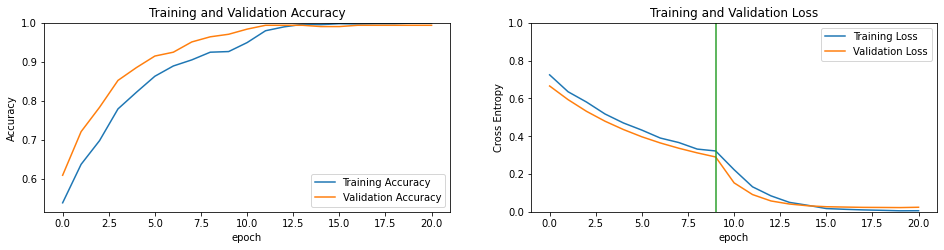

In [28]:
recall += history_fine.history['recall']
val_recall += history_fine.history['val_recall']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

accuracy += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

auc += history_fine.history['auc']
val_auc += history_fine.history['val_auc']

precision += history_fine.history['precision']
val_pre += history_fine.history['val_precision']

figure = plt.figure(figsize = (16, 16))

plt.subplot(4, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(4, 2, 1)
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

'''
plt.subplot(4, 2, 1)
plt.plot(recall, label = 'Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Recall')



plt.subplot(4, 2, 3)
plt.plot(auc, label = 'Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.ylabel('AUC')
plt.ylim([0.7,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation AUC')
plt.xlabel('epoch')

plt.subplot(4, 2, 4)
plt.plot(precision, label = 'Training Precision')
plt.plot(val_pre, label='Validation Precision')
plt.legend(loc='upper right')
plt.ylabel('Precision')
plt.ylim([0.7,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Precision')
plt.xlabel('epoch')

'''
plt.show()

figure.savefig("/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/plots/learning_curves_mobilenet.svg",
               dpi = 300)

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )


test_ds = test_ds.prefetch(buffer_size = AUTOTUNE)

## Verifying on test set

In [ ]:
loss, precision, recall, auc = model.evaluate(test_ds)
print('Test loss :', loss)
print('Test precision :', precision)
print('Test recall :', recall)
print('Test auc :', auc)

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# pred = model.predict(test_ds)
# pred = np.argmax(pred, axis = 1)[:5]
# label = 

# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)

In [ ]:
print(np.round(predictions, 3))

In [ ]:
predictions = tf.where(predictions < 0.5, 0, 1)
print(predictions)

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# pred = model.predict(test_ds)
# pred = np.argmax(pred, axis = 1)[:5]
# label = 

# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Saving model

In [ ]:
model.save('model00_MobileNetv3_Small.h5')

# LOOK AT EXTRACTING THE MISSCLASSIFIED IMAGES AND TALK ABOUT WHY THEY HAVE BEEN MISSCLASSIFIED (SIMILAR FEATURES, LOOKS LIKE A SUNSET ETC)

### Confusion Matrix

In [ ]:
import tensorflow as tf
import pathlib
import functions
data_dir = pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Training and Validation')
test_dir = pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Testing')

loaded_model = tf.keras.models.load_model('models/model00_MobileNetv3_Small.h5')
img_height, img_width, batch_size = [224, 224, 32]

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle = True,
    seed = 89787,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    labels = 'inferred',
    label_mode = 'binary'
    )


In [ ]:
confusion_matrix, cm = functions.ConfusionMatrix(loaded_model, 
                                             test_ds, 
                                             save_fig = True, 
                                             save_fig_location = "/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/plots/MobileNetV3_small/CM_NO_IA_1_MobileNetV3_small.svg")

In [ ]:
functions.CreateMetricsReport(model = loaded_model,
                             dataset = test_ds,
                             confusion_matrix = confusion_matrix)

## Testing on custom images

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os
import functions

loaded_model = tf.keras.models.load_model('models/model00_MobileNetv3_Small.h5')
input_shape = (224, 224)
img_directory = '/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Photos-001/'

test_preds = functions.TestImages(img_directory, input_shape, loaded_model)

In [ ]:
count = 0
for i in test_preds:
    if i>0.5:
        print("no fire")
    else:
        count += 1
        print("fire")
print('Incorrectly predicted ', count,  ' out of ',len(test_preds), '. FPR: ', round(count/len(test_preds), 2))

## Testing on other dataset

In [29]:
import tensorflow as tf
import functions

data_dir = '../../data/Alt_dataset/Training Dataset'
loaded_model = tf.keras.models.load_model('models/model00_MobileNetv3_Small.h5')

img_height, img_width, batch_size = [224, 224, 32] 

custom_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    seed = 89787,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    labels = 'inferred',
    label_mode = 'binary'
    )

## Check if images are in the right format

bad_file_list = functions.CheckImagesReport(data_dir)

Found 2204 files belonging to 2 classes.
processing class directory  NoFire
processing class directory  Fire
 no improper image files were found


In [ ]:
print(custom_test_ds.class_names)

In [ ]:
## Delete the incompatible files from the folder
functions.DeleteIncompatibleImages(bad_file_list)


In [ ]:
confusion_matrix, cm = functions.ConfusionMatrix(loaded_model, 
                                             custom_test_ds, 
                                             save_fig = True, 
                                             save_fig_location = "/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/plots/MobileNetV3_small/CM_NO_IA_2_MobileNetV3_small.svg")

In [ ]:
functions.CreateMetricsReport(model = loaded_model,
                             dataset = custom_test_ds,
                             confusion_matrix = confusion_matrix)

# Feature map extraction

from: https://towardsdatascience.com/convolutional-neural-network-feature-map-and-filter-visualization-f75012a5a49c

In [ ]:
img_path = f'{test_dir}/nofire/abc191.jpg'

In [ ]:
#Iterate thru all the layers of the model
for layer in base_model.layers:
    if 'conv' in layer.name:
        weights = layer.get_weights()
        print(weights)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

In [ ]:
type(model.layers[1])

['Fire', 'NoFire']


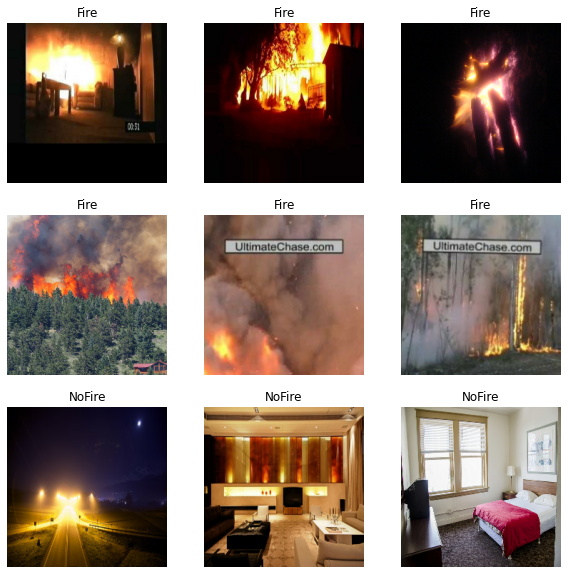

In [37]:

class_names = custom_test_ds.class_names
print(class_names)

plt.figure(figsize = (10, 10))
for images, labels in custom_test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
        
plt.savefig('../../images/dataset2.ps', dpi = 300)